# MIE1624 Assignment 2

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model

from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
# from sklearn.cross_validation import KFold # old version

from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
cur_dir = os.getcwd()
%matplotlib inline

## 1. Data cleaning
While the data is made ready for analysis, several values are missing, and some features are categorical.
For the data cleaning step, handle missing values however you see fit and justify your approach. Provide some insight on why you think the values are missing and how your approach might impact the overall analysis. Suggestions include filling the missing values with a certain value (e.g. mode for categorical data) and completely removing the features with missing values. Secondly, convert categorical data into numerical data by encoding and explain why you used this particular encoding method.
These tasks can be done interchangeably i.e. encoding can be done first.

In [2]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 400)

In [3]:
Salaries = pd.read_csv("Kaggle_Salary.csv", encoding = "ISO-8859-1", low_memory = False)

In [4]:
Salaries.head()

,Unnamed: 0,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,Q7_OTHER_TEXT,Q8,Q9,Q10,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q11_OTHER_TEXT,Q12_MULTIPLE_CHOICE,Q12_Part_1_TEXT,Q12_Part_2_TEXT,Q12_Part_3_TEXT,Q12_Part_4_TEXT,Q12_Part_5_TEXT,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_Part_13,Q13_Part_14,Q13_Part_15,Q13_OTHER_TEXT,Q14_Part_1,Q14_Part_2,Q14_Part_3,Q14_Part_4,Q14_Part_5,Q14_Part_6,Q14_Part_7,Q14_Part_8,Q14_Part_9,Q14_Part_10,Q14_Part_11,Q14_OTHER_TEXT,Q15_Part_1,Q15_Part_2,Q15_Part_3,Q15_Part_4,Q15_Part_5,Q15_Part_6,Q15_Part_7,Q15_OTHER_TEXT,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,Q16_Part_7,Q16_Part_8,Q16_Part_9,Q16_Part_10,Q16_Part_11,Q16_Part_12,Q16_Part_13,Q16_Part_14,Q16_Part_15,Q16_Part_16,Q16_Part_17,Q16_Part_18,Q16_OTHER_TEXT,Q17,Q17_OTHER_TEXT,Q18,Q18_OTHER_TEXT,Q19_Part_1,Q19_Part_2,Q19_Part_3,Q19_Part_4,Q19_Part_5,Q19_Part_6,Q19_Part_7,Q19_Part_8,Q19_Part_9,Q19_Part_10,Q19_Part_11,Q19_Part_12,Q19_Part_13,Q19_Part_14,Q19_Part_15,Q19_Part_16,Q19_Part_17,Q19_Part_18,Q19_Part_19,Q19_OTHER_TEXT,Q20,Q20_OTHER_TEXT,Q21_Part_1,Q21_Part_2,Q21_Part_3,Q21_Part_4,Q21_Part_5,Q21_Part_6,Q21_Part_7,Q21_Part_8,Q21_Part_9,Q21_Part_10,Q21_Part_11,Q21_Part_12,Q21_Part_13,Q21_OTHER_TEXT,Q22,Q22_OTHER_TEXT,Q23,Q24,Q25,Q26,Q27_Part_1,Q27_Part_2,Q27_Part_3,Q27_Part_4,Q27_Part_5,Q27_Part_6,Q27_Part_7,Q27_Part_8,Q27_Part_9,Q27_Part_10,Q27_Part_11,Q27_Part_12,Q27_Part_13,Q27_Part_14,Q27_Part_15,Q27_Part_16,Q27_Part_17,Q27_Part_18,Q27_Part_19,Q27_Part_20,Q27_OTHER_TEXT,Q28_Part_1,Q28_Part_2,Q28_Part_3,Q28_Part_4,Q28_Part_5,Q28_Part_6,Q28_Part_7,Q28_Part_8,Q28_Part_9,Q28_Part_10,Q28_Part_11,Q28_Part_12,Q28_Part_13,Q28_Part_14,Q28_Part_15,Q28_Part_16,Q28_Part_17,Q28_Part_18,Q28_Part_19,Q28_Part_20,Q28_Part_21,Q28_Part_22,Q28_Part_23,Q28_Part_24,Q28_Part_25,Q28_Part_26,Q28_Part_27,Q28_Part_28,Q28_Part_29,Q28_Part_30,Q28_Part_31,Q28_Part_32,Q28_Part_33,Q28_Part_34,Q28_Part_35,Q28_Part_36,Q28_Part_37,Q28_Part_38,Q28_Part_39,Q28_Part_40,Q28_Part_41,Q28_Part_42,Q28_Part_43,Q28_OTHER_TEXT,Q29_Part_1,Q29_Part_2,Q29_Part_3,Q29_Part_4,Q29_Part_5,Q29_Part_6,Q29_Part_7,Q29_Part_8,Q29_Part_9,Q29_Part_10,Q29_Part_11,Q29_Part_12,Q29_Part_13,Q29_Part_14,Q29_Part_15,Q29_Part_16,Q29_Part_17,Q29_Part_18,Q29_Part_19,Q29_Part_20,Q29_Part_21,Q29_Part_22,Q29_Part_23,Q29_Part_24,Q29_Part_25,Q29_Part_26,Q29_Part_27,Q29_Part_28,Q29_OTHER_TEXT,Q30_Part_1,Q30_Part_2,Q30_Part_3,Q30_Part_4,Q30_Part_5,Q30_Part_6,Q30_Part_7,Q30_Part_8,Q30_Part_9,Q30_Part_10,Q30_Part_11,Q30_Part_12,Q30_Part_13,Q30_Part_14,Q30_Part_15,Q30_Part_16,Q30_Part_17,Q30_Part_18,Q30_Part_19,Q30_Part_20,Q30_Part_21,Q30_Part_22,Q30_Part_23,Q30_Part_24,Q30_Part_25,Q30_OTHER_TEXT,Q31_Part_1,Q31_Part_2,Q31_Part_3,Q31_Part_4,Q31_Part_5,Q31_Part_6,Q31_Part_7,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q31_OTHER_TEXT,Q32,Q32_OTHER,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_OTHER_TEXT,Q35_Part_1,Q35_Part_2,Q35_Part_3,Q35_Part_4,Q35_Part_5,Q35_Part_6,Q35_OTHER_TEXT,Q36_Part_1,Q36_Part_2,Q36_Part_3,Q36_Part_4,Q36_Part_5,Q36_Part_6,Q36_Part_7,Q36_Part_8,Q36_Part_9,Q36_Part_10,Q36_Part_11,Q36_Part_12,Q36_Part_13,Q36_OTHER_TEXT,Q37,Q37_OTHER_TEXT,Q38_Part_1,Q38_Part_2,Q38_Part_3,Q38_Part_4,Q38_Part_5,Q38_Part_6,Q38_Part_7,Q38_Part_8,Q38_Part_9,Q38_Part_10,Q38_Part_11,Q38_Part_12,Q38_Part_13,Q38_Part_14,Q38_Part_15,Q38_Part_16,Q38_Part_17,Q38_Part_18,Q38_Part_19,Q38_Part_20,Q38_Part_21,Q38_Part_22,Q38_OTHER_TEXT,Q39_Part_1,Q39_Part_2,Q40,Q41_Part_1,Q41_Part_2,Q41_Part_3,Q42_Part_1,Q42_Part_2,Q42_Part_3,Q42_Part_4,Q42_Part_5,Q42_OTHER_TEXT,Q43,Q44_Part_1,Q44_Part_2,Q44_Part_3,Q44_Part_4,Q44_Part_5,Q44_Part_6,Q45_Part_1,Q45_P

In [5]:
ten_col = Salaries.loc[:,['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q17']]

In [6]:
rename = ten_col.rename(columns = {'Q1':'Gender', 'Q2':'Age', 'Q3':'Country', 'Q4':'Education', 
                          'Q5':'Major', 'Q6': 'Role', 'Q7':'Industry', 'Q8':'Years', 
                          'Q9':'Compensation', 'Q17':'Language'})

In [7]:
new_ten_col = rename.drop(rename.index[0])
new_ten_col.head()

,Gender,Age,Country,Education,Major,Role,Industry,Years,Compensation,Language
1,Male,30-34,Indonesia,Bachelorâs degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,18668,NaN
2,Female,30-34,United States of America,Masterâs degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,2726,Java
3,Male,22-24,India,Masterâs degree,Mathematics or statistics,Data Analyst,I am a student,0-1,682,SQL
4,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,Academics/Education,10-15,11957,NaN
5,Male,18-21,India,Masterâs degree,"Information technology, networking, or system ...",Other,Other,0-1,2696,NaN


In [8]:
new_ten_col['Gender'].value_counts(normalize=True)

Male                       0.833884
Female                     0.154255
Prefer not to say          0.008426
Prefer to self-describe    0.003435
Name: Gender, dtype: float64

In [9]:
new_ten_col['Age'].value_counts(normalize=True).head(10)

25-29    0.277270
22-24    0.187569
30-34    0.182708
35-39    0.106099
18-21    0.088340
40-44    0.064100
45-49    0.039017
50-54    0.026120
55-59    0.014388
60-69    0.011666
Name: Age, dtype: float64

In [10]:
new_ten_col['Country'].value_counts(normalize=True).head(10)

United States of America                                0.219911
India                                                   0.150366
China                                                   0.056387
Other                                                   0.043878
Russia                                                  0.037656
Brazil                                                  0.036101
Germany                                                 0.032795
United Kingdom of Great Britain and Northern Ireland    0.032082
Canada                                                  0.028583
France                                                  0.027416
Name: Country, dtype: float64

In [11]:
new_ten_col['Education'].value_counts(normalize=True)

Masterâs degree                                                      0.472228
Bachelorâs degree                                                    0.284075
Doctoral degree                                                        0.163458
Some college/university study without earning a bachelorâs degree    0.038175
Professional degree                                                    0.024888
No formal education past high school                                   0.008750
I prefer not to answer                                                 0.008426
Name: Education, dtype: float64

In [12]:
new_ten_col['Major'].value_counts(normalize=True)

Computer science (software engineering, etc.)                   0.388191
Engineering (non-computer focused)                              0.161436
Mathematics or statistics                                       0.135609
A business discipline (accounting, economics, finance, etc.)    0.084347
Physics or astronomy                                            0.055120
                                                                  ...   
Social sciences (anthropology, psychology, sociology, etc.)     0.027004
Humanities (history, literature, philosophy, etc.)              0.013731
Environmental science or geology                                0.011442
I never declared a major                                        0.004446
Fine arts or performing arts                                    0.003858
Name: Major, Length: 13, dtype: float64

In [13]:
new_ten_col['Role'].value_counts(normalize=True)

Data Scientist            0.210577
Student                   0.169810
Software Engineer         0.151662
Data Analyst              0.092553
Other                     0.066044
                            ...   
Marketing Analyst         0.005639
Developer Advocate        0.005509
Principal Investigator    0.005379
Salesperson               0.005185
Data Journalist           0.000648
Name: Role, Length: 20, dtype: float64

In [14]:
new_ten_col['Industry'].value_counts(normalize=True)

Computers/Technology                    0.270854
I am a student                          0.145700
Academics/Education                     0.128395
Accounting/Finance                      0.076544
Other                                   0.048610
                                          ...   
Online Business/Internet-based Sales    0.017629
Shipping/Transportation                 0.015361
Non-profit/Service                      0.009916
Hospitality/Entertainment/Sports        0.009852
Military/Security/Defense               0.009722
Name: Industry, Length: 19, dtype: float64

In [15]:
new_ten_col['Years'].value_counts(normalize=True).head(10)

0-1      0.252654
1-2      0.184068
5-10     0.128509
2-3      0.127988
3-4      0.085195
4-5      0.074578
10-15    0.073145
15-20    0.038755
20-25    0.017651
30 +     0.009379
Name: Years, dtype: float64

In [16]:
new_ten_col['Language'].value_counts(normalize=True)

Python    0.529040
R         0.137626
SQL       0.090097
Java      0.056187
C/C++     0.041847
            ...   
Scala     0.007305
Bash      0.004058
Ruby      0.003788
Go        0.003157
Julia     0.000631
Name: Language, Length: 17, dtype: float64

In [17]:
# remove the rows with Gender is 'Prefer not to say' and 'Prefer to self-describ'
gender = new_ten_col[new_ten_col['Gender'].isin(['Female','Male'])]

In [18]:
# remove the rows with Education is 'I prefer not to answer'
education = gender[~gender[gender=='I prefer not to answer'].any(axis=1)]

In [19]:
# remove the rows with Major is 'I never declared a major'
major = education[~education[education=='I never declared a major'].any(axis=1)]

In [20]:
# rename USA and UK
rename_country = major.replace({'Country':{'United States of America':'USA',
                                           'United Kingdom of Great Britain and Northern Ireland':'UK'}})
# keep the top 8 mentioned countries
country = rename_country[rename_country['Country'].isin(['USA','India','China','Russia', 'Brazil', 'Germany', 'UK', 'Canada'])]

In [21]:
country

,Gender,Age,Country,Education,Major,Role,Industry,Years,Compensation,Language
2,Female,30-34,USA,Masterâs degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,2726,Java
3,Male,22-24,India,Masterâs degree,Mathematics or statistics,Data Analyst,I am a student,0-1,682,SQL
5,Male,18-21,India,Masterâs degree,"Information technology, networking, or system ...",Other,Other,0-1,2696,NaN
7,Male,40-44,USA,Masterâs degree,Engineering (non-computer focused),Data Scientist,Other,5-10,132826,Java
9,Male,25-29,USA,Bachelorâs degree,Mathematics or statistics,Research Assistant,Academics/Education,1-2,35826,Python
...,...,...,...,...,...,...,...,...,...,...
15413,Male,30-34,India,Masterâs degree,"Computer science (software engineering, etc.)",Data Scientist,Computers/Technology,5-10,6681,C#/.NET
15418,Male,35-39,UK,Doctoral degree,"Computer science (software engineering, etc.)",Research Scientist,Academics/Education,10-15,76917,C/C++
15421,Male,25-29,Russia,Masterâs degree,"Computer science (software engineering, etc.)",Product/Project Manager,Shipping/Transportation,2-3,10419,NaN
15423,Female,22-24,India,Masterâs degree,"Information technology, networking, or system ...",Student,Computers/Technology,20-25,12108,Python


In [22]:
# merge the age ranges
age = country.replace({'Age':{'22-24':'22-29','25-29':'22-29', 
                             '30-34':'30-39','35-39':'30-39',
                             '40-44':'40-49','45-49':'40-49',
                             '50-54':'50-59','55-59':'50-59'}})

In [23]:
# merge the year ranges
year = age.replace({'Years':{'1-2':'1-3', '2-3':'1-3', '3-4':'3-5','4-5':'3-5', '20-25':'20-30', '25-30':'20-30'}})

In [24]:
# replace NaN in Language with Unknown
year.loc[year['Language'].isnull(),'Language'] = 'Unknown'

In [25]:
remove_nan = year.dropna()

In [26]:
clean_data = remove_nan.reset_index(drop = True)

In [27]:
clean_data.head()

,Gender,Age,Country,Education,Major,Role,Industry,Years,Compensation,Language
0,Female,30-39,USA,Masterâs degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,2726,Java
1,Male,22-29,India,Masterâs degree,Mathematics or statistics,Data Analyst,I am a student,0-1,682,SQL
2,Male,18-21,India,Masterâs degree,"Information technology, networking, or system ...",Other,Other,0-1,2696,Unknown
3,Male,40-49,USA,Masterâs degree,Engineering (non-computer focused),Data Scientist,Other,5-10,132826,Java
4,Male,22-29,USA,Bachelorâs degree,Mathematics or statistics,Research Assistant,Academics/Education,1-3,35826,Python


In [28]:
salary_list = []
salary = clean_data['Compensation']
for i in salary:
    salary_list.append(int(i))

In [29]:
clean_data['Compensation']=salary_list

In this part, I selected 10 qustions, which is Q1 to Q9 and Q17, since I think these questions contain the information that affect ones yearly compensation significantly. After question selection, I replace the question number and question itself with my own title to make the later operations easier. Use normalization to see the fraction for each choices. For countries, I selected the rows contain top 8 mentioned countries, since these data give more analytical information. Remove the rows with answers like 'I prefer not to answer', since they will influence the information completion of our dataset. I did a reasonable merge of choices for question about years and age. For the programming language, I filled the missing value with 'unknown'. And I dropped all other rows with missing values.

In [130]:
features = pd.get_dummies(data=clean_data, columns=['Gender','Age','Country','Education','Major',
                                                    'Role','Industry','Years','Language'])

In [131]:
features

,Compensation,Gender_Female,Gender_Male,Age_18-21,Age_22-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,Age_70-79,Age_80+,Country_Brazil,Country_Canada,Country_China,Country_Germany,Country_India,Country_Russia,Country_UK,Country_USA,Education_Bachelorâs degree,Education_Doctoral degree,Education_Masterâs degree,Education_Professional degree,Education_Some college/university study without earning a bachelorâs degree,"Major_A business discipline (accounting, economics, finance, etc.)","Major_Computer science (software engineering, etc.)",Major_Engineering (non-computer focused),Major_Environmental science or geology,Major_Fine arts or performing arts,"Major_Humanities (history, literature, philosophy, etc.)","Major_Information technology, networking, or system administration",Major_Mathematics or statistics,"Major_Medical or life sciences (biology, chemistry, medicine, etc.)",Major_Other,Major_Physics or astronomy,"Major_Social sciences (anthropology, psychology, sociology, etc.)",Role_Business Analyst,Role_Chief Officer,Role_Consultant,Role_DBA/Database Engineer,Role_Data Analyst,Role_Data Engineer,Role_Data Journalist,Role_Data Scientist,Role_Developer Advocate,Role_Manager,Role_Marketing Analyst,Role_Other,Role_Principal Investigator,Role_Product/Project Manager,Role_Research Assistant,Role_Research Scientist,Role_Salesperson,Role_Software Engineer,Role_Statistician,Role_Student,Industry_Academics/Education,Industry_Accounting/Finance,Industry_Broadcasting/Communications,Industry_Computers/Technology,Industry_Energy/Mining,Industry_Government/Public Service,Industry_Hospitality/Entertainment/Sports,Industry_I am a student,Industry_Insurance/Risk Assessment,Industry_Manufacturing/Fabrication,Industry_Marketing/CRM,Industry_Medical/Pharmaceutical,Industry_Military/Security/Defense,Industry_Non-profit/Service,Industry_Online Business/Internet-based Sales,Industry_Online Service/Internet-based Services,Industry_Other,Industry_Retail/Sales,Industry_Shipping/Transportation,Years_0-1,Years_1-3,Years_10-15,Years_15-20,Years_20-30,Years_3-5,Years_30 +,Years_5-10,Language_Bash,Language_C#/.NET,Language_C/C++,Language_Go,Language_Java,Language_Javascript/Typescript,Language_Julia,Language_MATLAB,Language_Other,Language_PHP,Language_Python,Language_R,Language_Ruby,Language_SAS/STATA,Language_SQL,Language_Scala,Language_Unknown,Language_Visual Basic/VBA
0,2726,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,682,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2696,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,132826,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,35826,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8845,6681,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In this step, I use dummy encoding to convert categorical data into numerical data. The reason is that it can create a sparse dataframe with boolean elements and indicates each persons choice clearly. This encoding method will experience a shower pocession time.

## 2. Exploratory data analysis

### (a)
Present 3 graphical figures that represent trends in the data. How could these trends be used to help with the task of predicting yearly compensation or understanding the data? All graphs should be readable and have all axes appropriately labelled.

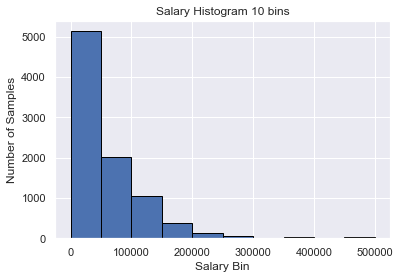

In [31]:
plt.hist(salary_list, bins=10, edgecolor='black')
plt.title("Salary Histogram 10 bins")
plt.xlabel("Salary Bin")
plt.ylabel("Number of Samples")
plt.show()

This histogram shows the number of people in each yearly salary range. We can figure out that most of them are in 0 to 50000 range and the count of people in each range is decreasing in a steeping rate.

/Users/Izzy_0911/anaconda3/lib/python3.5/site-packages/pandas/plotting/_core.py:2396: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  yrot=yrot, **kwds)


Text(0.5,1,'salary distribution for each country')

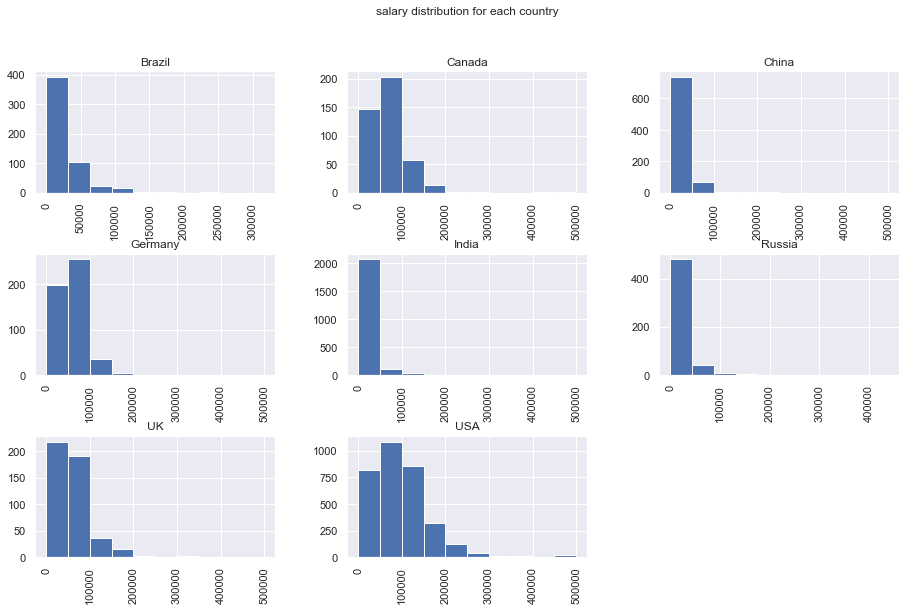

In [194]:
fig = plt.figure(figsize = (15,9))
ax = fig.gca()
clean_data.hist('Compensation', bins = 10, by = 'Country', ax = ax)
plt.suptitle('salary distribution for each country', x=0.5, y=1, ha='center', fontsize='large')

This eight figures show the number of people in each yearly salary range in eight selected countries. From the figure, we can say that people in USA have the highest average salary. Most of people in China, Russia, India and Brazil are receiving salaries in the lowest range, which is 0 to 50000USD

[Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,'')]

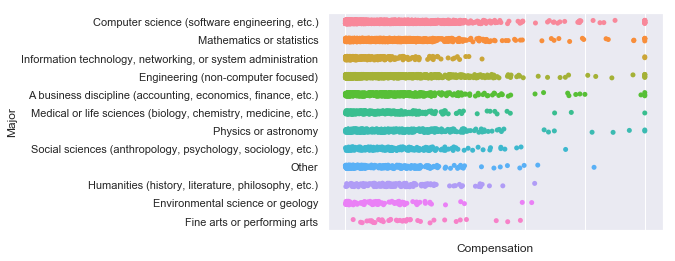

In [33]:
ax = sns.stripplot(x="Compensation", y="Major", data=clean_data, jitter=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

From the scatter plot, we can say that the yearly salary for people major in computer science, mathematics or statistics, engineering, business discipline and physics or astronomy would usually be higher. 

[Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,'')]

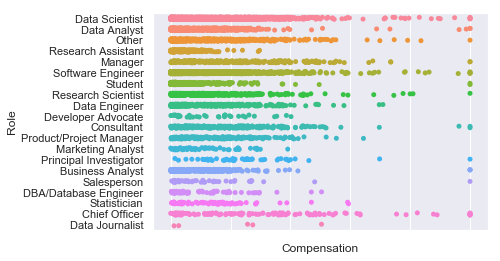

In [34]:
ax = sns.stripplot(x="Compensation", y="Role", data=clean_data, jitter=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

From this scatter plot, we can say that people's current row in data scientist, manager, software engineer, research scientist, data engineer, consultant, chief officer are more likely to have higher compensation.

[Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,'')]

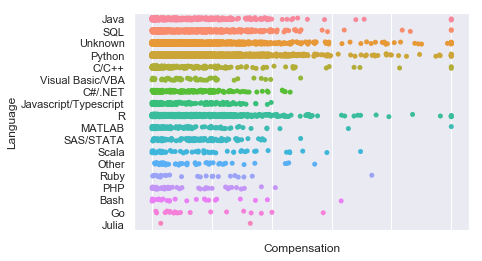

In [35]:
ax = sns.stripplot(x="Compensation", y="Language", data=clean_data, jitter=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

This scatter plot indicates that people with high compensation are usually work with Java, SQL, Python, C/C++ and R. So we may suggest people to learn these languages to improve their compensation level.

[Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,''),
 Text(0,0,'')]

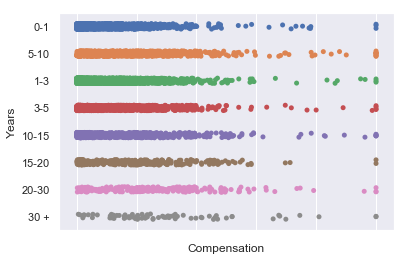

In [36]:
ax = sns.stripplot(x="Compensation", y="Years", data=clean_data, jitter=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

This figure demonstrate that the years of experience one have in his/her role does not have a clear effect on the compensation level, which means length of working years has no dirct effect to salary.

### (b)
Visualize the order of feature importance. Some possible methods include correlation plot, or a similar method. Given the data, which of the original attributes in the data are most related to a survey respondent’s yearly compensation?

In [37]:
from sklearn.preprocessing import LabelEncoder

nu_clean_data = clean_data[clean_data.columns[[0,1,2,3,4,5,6,7,8,9]]]

labelencoder = LabelEncoder()
    
nu_clean_data['Gender'] = labelencoder.fit_transform(nu_clean_data['Gender'])
nu_clean_data['Age'] = labelencoder.fit_transform(nu_clean_data['Age'])
nu_clean_data['Country'] = labelencoder.fit_transform(nu_clean_data['Country'])
nu_clean_data['Education'] = labelencoder.fit_transform(nu_clean_data['Education'])
nu_clean_data['Major'] = labelencoder.fit_transform(nu_clean_data['Major'])
nu_clean_data['Role'] = labelencoder.fit_transform(nu_clean_data['Role'])
nu_clean_data['Industry'] = labelencoder.fit_transform(nu_clean_data['Industry'])
nu_clean_data['Years'] = labelencoder.fit_transform(nu_clean_data['Years'])
nu_clean_data['Language'] = labelencoder.fit_transform(nu_clean_data['Language'])

In [38]:
nu_clean_data

,Gender,Age,Country,Education,Major,Role,Industry,Years,Compensation,Language
0,0,2,7,2,1,7,7,0,2726,4
1,1,1,4,2,7,4,7,0,682,14
2,1,0,4,2,6,11,16,0,2696,16
3,1,3,7,2,2,7,16,7,132826,4
4,1,1,7,0,7,14,0,1,35826,10
...,...,...,...,...,...,...,...,...,...,...
8845,1,2,4,2,1,7,3,7,6681,1
8846,1,2,6,1,1,15,0,2,76917,2
8847,1,1,5,2,1,13,18,1,10419,16
8848,0,1,4,2,6,19,3,4,12108,10


In [39]:
corr = nu_clean_data.corr()
corr

,Gender,Age,Country,Education,Major,Role,Industry,Years,Compensation,Language
Gender,1.000000,0.031595,-0.102231,-0.040584,-0.068249,0.014162,-0.002689,0.068582,0.018306,-0.074344
Age,0.031595,1.000000,0.152441,0.118453,0.122769,-0.265815,-0.015754,0.360129,0.447526,-0.023415
Country,-0.102231,0.152441,1.000000,0.019774,0.159231,-0.093612,0.066453,0.010028,0.374498,0.045717
Education,-0.040584,0.118453,0.019774,1.000000,0.044457,-0.067360,0.016932,0.029857,0.053618,0.023721
Major,-0.068249,0.122769,0.159231,0.044457,1.000000,-0.076573,0.028235,0.015689,0.102531,0.049979
Role,0.014162,-0.265815,-0.093612,-0.067360,-0.076573,1.000000,-0.120247,-0.043242,-0.245943,-0.170266
Industry,-0.002689,-0.015754,0.066453,0.016932,0.028235,-0.120247,1.000000,-0.022388,0.052624,0.043580
Years,0.068582,0.360129,0.010028,0.029857,0.015689,-0.043242,-0.022388,1.000000,0.198357,-0.056059
Compensation,0.018306,0.447526,0.374498,0.053618,0.102531,-0.245943,0.052624,0.198357,1.000000,-0.008256
Language,-0.074344,-0.023415,0.045717,0.023721,0.049979,-0.170266,0.043580,-0.056059,-0.008256,1.000000


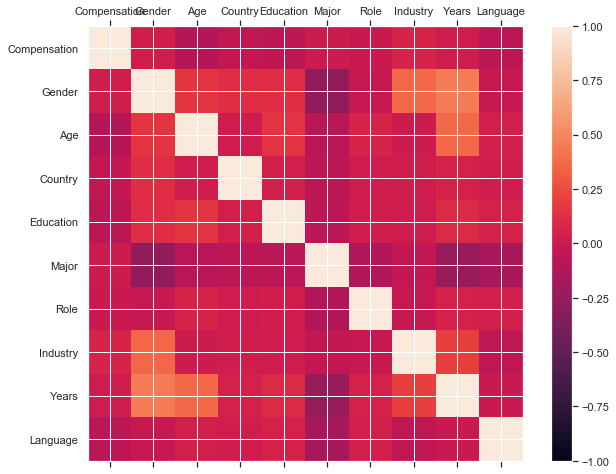

In [42]:
correlations = nu_clean_data.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,10,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(['Compensation','Gender','Age','Country','Education','Major','Role','Industry','Years','Language'])
ax.set_yticklabels(['Compensation','Gender','Age','Country','Education','Major','Role','Industry','Years','Language'])
figure=plt.gcf()
figure.set_size_inches(10,8)
plt.show()

In order to draw the correlation plot, I use the label encoder, which also convert the categorical data into numerical data. In the correlation plot, each colored square indicates the relationship between two attributes, and a value closer to 1 denotes two items are highly correlated. So the correlations on diagonal are all equal 1. For our purpose, we look at the first row of the plot to study the correlation between each attribute and yearly compensation. We can say the compensation is closely correlated to age, country, major, years (in role).

## 3. Feature selection
Explain how feature engineering is a useful tool in machine learning. Then select the features to be used for analysis either manually or through some feature selection algorithm (e.g. regularized regression). Not all features need to be used; features can be removed or added as desired. If the resulting number of features is very high, dimensionality reduction can also be used (e.g. PCA). Use at least one feature selection technique, and provide justification on why you selected the set of features.

In [132]:
Salaries_Train,Salaries_Test = train_test_split(features,test_size=0.33, random_state=13)
Salaries_Y = Salaries_Train['Compensation']
Salaries_X = Salaries_Train.drop(['Compensation'], axis=1)
Salaries_Y_Test = Salaries_Test['Compensation']
Salaries_X_Test = Salaries_Test.drop(['Compensation'], axis=1)

In [133]:
#set up cross validation

def run_kfold(model):
    
    X = Salaries_X
    Y = Salaries_Y
    
    kf = KFold(n_splits=10) #n_splits previously n_folds
    
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        accuracy = r2_score(Y_test, predictions) # can try mean absolute error instead
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))   
        
    mean_outcome = np.mean(outcomes)
    std_outcome=np.std(outcomes)
    print("Mean r2: {0}".format(mean_outcome)) 
    print("Standard Deviation: {0}".format(std_outcome)) 

In [134]:
model_lr = linear_model.LinearRegression()
run_kfold (model_lr)

predictions = model_lr.predict(Salaries_X_Test)
Test_Score = r2_score(Salaries_Y_Test, predictions)

print ("------------------\n Test Score: " + str(Test_Score))

Fold 1 accuracy: 0.3911800371716353
Fold 2 accuracy: -2.7579858490709893e+18
Fold 3 accuracy: 0.5407931813244737
Fold 4 accuracy: 0.4226781991017683
Fold 5 accuracy: 0.43093649561235325
Fold 6 accuracy: 0.4300359104305308
Fold 7 accuracy: 0.47946627353925153
Fold 8 accuracy: 0.4613949375299474
Fold 9 accuracy: 0.4551411454013433
Fold 10 accuracy: 0.44351686173629834
Mean r2: -2.7579858490709894e+17
Standard Deviation: 8.273957547212968e+17
------------------
 Test Score: 0.4537162529665517


In [135]:
mean_absolute_error(Salaries_Y_Test,predictions)

29665.230058199246

In [136]:
print(sorted(list(zip(model_lr.coef_, Salaries_X)),reverse=True)[0:10])

[(6.819127456043278e+17, 'Education_Doctoral degree'), (6.81912745604321e+17, 'Education_Masterâ\x80\x99s degree'), (6.819127456043192e+17, 'Education_Bachelorâ\x80\x99s degree'), (6.819127456043149e+17, 'Education_Professional degree'), (6.819127456043114e+17, 'Education_Some college/university study without earning a bachelorâ\x80\x99s degree'), (2.946910726505911e+17, 'Role_Chief Officer'), (2.946910726505789e+17, 'Role_Data Journalist'), (2.946910726505621e+17, 'Role_Principal Investigator'), (2.9469107265054746e+17, 'Role_Manager'), (2.94691072650538e+17, 'Role_Data Scientist')]


In [137]:
rfe = RFE(model_lr)
fit = rfe.fit(Salaries_X[0:10000], Salaries_Y[0:10000])

In [138]:
sorted(list(zip(fit.ranking_,Salaries_X))[0:25])

[(1, 'Country_Brazil'),
 (1, 'Country_Canada'),
 (1, 'Country_China'),
 (1, 'Country_Germany'),
 (1, 'Country_India'),
 (1, 'Country_Russia'),
 (1, 'Country_UK'),
 (1, 'Country_USA'),
 (1, 'Education_Bachelorâ\x80\x99s degree'),
 (1, 'Education_Doctoral degree'),
 (1, 'Education_Masterâ\x80\x99s degree'),
 (1, 'Education_Professional degree'),
 (1,
  'Education_Some college/university study without earning a bachelorâ\x80\x99s degree'),
 (1, 'Major_A business discipline (accounting, economics, finance, etc.)'),
 (1, 'Major_Computer science (software engineering, etc.)'),
 (4, 'Age_80+'),
 (5, 'Age_22-29'),
 (6, 'Age_18-21'),
 (7, 'Age_30-39'),
 (8, 'Age_40-49'),
 (9, 'Age_70-79'),
 (10, 'Age_60-69'),
 (11, 'Age_50-59'),
 (50, 'Gender_Male'),
 (51, 'Gender_Female')]

In [139]:
reg = linear_model.Lasso(alpha = 0.5,max_iter=10000)
reg.fit(Salaries_X, Salaries_Y)
reg.score(Salaries_X, Salaries_Y)

0.4725147940553903

In [140]:
from sklearn.metrics import make_scorer, r2_score, confusion_matrix

reg_gridsearch = linear_model.Lasso(random_state=42)
#Parameters to test
parameters = {'alpha':[0.5,1,3], # Constant that multiplies the L1 term. Defaults to 1.0.
             'normalize':[True,False]} #

# Compare parameters by score of model 
acc_scorer_lm = make_scorer(r2_score)

# Run the grid search
grid_obj_lm = GridSearchCV(reg_gridsearch, parameters, scoring=acc_scorer_lm)
grid_obj_lm = grid_obj_lm.fit(Salaries_X, Salaries_Y)

reg_gridsearch = grid_obj_lm.best_estimator_  #Select best parameter combination

/Users/Izzy_0911/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Izzy_0911/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Izzy_0911/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Izzy_0911/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Obje

In [141]:
reg_gridsearch

Lasso(alpha=3, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
   positive=False, precompute=False, random_state=42, selection='cyclic',
   tol=0.0001, warm_start=False)

In [142]:
reg_gridsearch.fit(Salaries_X, Salaries_Y)
reg_gridsearch.score(Salaries_X, Salaries_Y)

0.47165088555415075

In [143]:
print('alpha (Constant that multiplies the L1 term):',grid_obj_lm.best_estimator_.alpha) 
print('normalize:',grid_obj_lm.best_estimator_.normalize)

alpha (Constant that multiplies the L1 term): 3
normalize: True


In [144]:
predictions_lasso=reg_gridsearch.predict(Salaries_X_Test)

In [145]:
mean_absolute_error(Salaries_Y_Test,predictions_lasso)

28993.31525870137

In [146]:
run_kfold (reg)

Fold 1 accuracy: 0.3921393090284172
Fold 2 accuracy: 0.45874030860367
Fold 3 accuracy: 0.5382391192238407
Fold 4 accuracy: 0.42290370794190935
Fold 5 accuracy: 0.43646488657065685
Fold 6 accuracy: 0.4409723240977427
Fold 7 accuracy: 0.4797224310549574
Fold 8 accuracy: 0.46147773024800687
Fold 9 accuracy: 0.45571589715921
Fold 10 accuracy: 0.4628283843832681
Mean r2: 0.45492040983116794
Standard Deviation: 0.03630371576471202


In [147]:
sorted(list(zip(reg.coef_, Salaries_X)),reverse=True)[0:25]

[(64561.38958305956, 'Role_Chief Officer'),
 (45401.971628963955, 'Role_Data Journalist'),
 (41704.88504739997, 'Years_30 +'),
 (39757.67181991043, 'Country_USA'),
 (34227.696430638105, 'Language_Go'),
 (31795.194241709578, 'Role_Principal Investigator'),
 (29484.856536074767, 'Language_Scala'),
 (18742.73350701223, 'Role_Manager'),
 (18720.131835508102, 'Industry_Online Business/Internet-based Sales'),
 (17829.656457168254, 'Age_50-59'),
 (13905.141521914862, 'Industry_Accounting/Finance'),
 (12985.010711470655, 'Years_15-20'),
 (11678.931475485826, 'Years_20-30'),
 (10583.299212780472, 'Industry_Online Service/Internet-based Services'),
 (9913.844234860708, 'Role_Developer Advocate'),
 (9831.178420987137, 'Education_Doctoral degree'),
 (9313.86061884085, 'Age_40-49'),
 (8611.43561846702, 'Major_Physics or astronomy'),
 (8401.95850326179, 'Role_Data Scientist'),
 (8037.867174122248, 'Country_Canada'),
 (7556.213485717594, 'Role_Consultant'),
 (7490.897408103252, 'Industry_Energy/Minin

In [148]:
rfe_lasso = RFE(reg)
fit_lasso = rfe_lasso.fit(Salaries_X[0:10000], Salaries_Y[0:10000])

In [149]:
sorted(list(zip(model_lr.coef_, Salaries_X))[0:25])

[(-2.776678752735485e+18, 'Age_80+'),
 (-2.7766787527353544e+18, 'Age_22-29'),
 (-2.7766787527353487e+18, 'Age_18-21'),
 (-2.7766787527353395e+18, 'Age_30-39'),
 (-2.776678752735325e+18, 'Age_60-69'),
 (-2.776678752735314e+18, 'Age_40-49'),
 (-2.7766787527353103e+18, 'Age_70-79'),
 (-2.776678752735307e+18, 'Age_50-59'),
 (-2.7233053143882527e+18, 'Country_Russia'),
 (-2.7233053143882486e+18, 'Country_Brazil'),
 (-2.723305314388234e+18, 'Country_India'),
 (-2.7233053143882296e+18, 'Country_China'),
 (-2.723305314388217e+18, 'Country_Germany'),
 (-2.723305314388214e+18, 'Country_UK'),
 (-2.7233053143882056e+18, 'Country_Canada'),
 (-2.723305314388177e+18, 'Country_USA'),
 (-1.9426744542381174e+18,
  'Major_Computer science (software engineering, etc.)'),
 (-1.942674454238117e+18,
  'Major_A business discipline (accounting, economics, finance, etc.)'),
 (-2674891487094237.0, 'Gender_Female'),
 (-2674891487091032.5, 'Gender_Male'),
 (6.819127456043114e+17,
  'Education_Some college/univers

Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. It is the composites of variable which can help quntify the relationship between inputs or variables. Different features are suitable for different tasks, and the appropriation of feature seletion can affect the accuracy of models. I first use the linear regression, however, the standard deviation would be so large and the fitted model is very bias, so we try regularization regression. By using lasso regression (linear model), we can get the 25 most correlated features with compensation in our dummied model, and remove the other features to avoid overfitting problem and to receive higher accuracy.

## 4. Model implementation
Implement 4 different regression/prediction algorithms of your choice on the training data using 10-fold cross-validation. How does your model accuracy compare across the folds? What is average and variance of accuracy for folds? Which model performed best? Give the reason based on bias-variance trade-off. For each algorithm, briefly talk about what it does, what its pros and cons are, and why you chose that algorithm.
### Selected Algorithm
1. Linear Regression
2. Decision Tree Regression
3. Ridge Regression
4. KNN

In [159]:
select_train = Salaries_Train.loc[:,['Compensation','Age_80+', 'Age_22-29', 'Age_18-21', 'Age_30-39', 'Age_60-69', 'Age_40-49',
                                'Age_70-79', 'Age_50-59', 'Country_Russia', 'Country_Brazil', 'Country_India',
                                'Country_China', 'Country_Germany', 'Country_UK', 'Country_Canada', 'Country_USA',
                                'Major_Computer science (software engineering, etc.)',
                                 'Major_A business discipline (accounting, economics, finance, etc.)',
                                'Gender_Female', 'Gender_Male', 
                                'Education_Some college/university study without earning a bachelorâ\x80\x99s degree',
                                'Education_Professional degree', 'Education_Bachelorâ\x80\x99s degree',
                                'Education_Masterâ\x80\x99s degree', 'Education_Doctoral degree']]

In [160]:
select_test = Salaries_Test.loc[:,['Compensation','Age_80+', 'Age_22-29', 'Age_18-21', 'Age_30-39', 'Age_60-69', 'Age_40-49',
                                'Age_70-79', 'Age_50-59', 'Country_Russia', 'Country_Brazil', 'Country_India',
                                'Country_China', 'Country_Germany', 'Country_UK', 'Country_Canada', 'Country_USA',
                                'Major_Computer science (software engineering, etc.)',
                                 'Major_A business discipline (accounting, economics, finance, etc.)',
                                'Gender_Female', 'Gender_Male', 
                                'Education_Some college/university study without earning a bachelorâ\x80\x99s degree',
                                'Education_Professional degree', 'Education_Bachelorâ\x80\x99s degree',
                                'Education_Masterâ\x80\x99s degree', 'Education_Doctoral degree']]

In [161]:
select_Salaries_Y = select_train['Compensation']
select_Salaries_X = select_train.drop(['Compensation'], axis=1)
select_Salaries_Y_Test = select_test['Compensation']
select_Salaries_X_Test = select_test.drop(['Compensation'], axis=1)

### Linear Regression

In [162]:
def run_kfold_new(model):
    
    X = select_Salaries_X
    Y = select_Salaries_Y
    
    kf = KFold(n_splits=10) #n_splits previously n_folds
    
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        accuracy = r2_score(Y_test, predictions) # can try mean absolute error instead
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))   
        
    mean_outcome = np.mean(outcomes)
    std_outcome=np.std(outcomes)
    print("Mean r2: {0}".format(mean_outcome)) 
    print("Standard Deviation: {0}".format(std_outcome)) 

In [184]:
select_model_lr = linear_model.LinearRegression()
run_kfold_new(select_model_lr)

linear_predictions = select_model_lr.predict(select_Salaries_X_Test)
Test_Score = r2_score(select_Salaries_Y_Test, linear_predictions)

print ("------------------\n Linear Regression Score: " + str(Test_Score))

Fold 1 accuracy: 0.32683703581307966
Fold 2 accuracy: 0.3792773450972421
Fold 3 accuracy: 0.4532120001294385
Fold 4 accuracy: 0.33397798075994223
Fold 5 accuracy: 0.3569838458211637
Fold 6 accuracy: 0.3741248292353495
Fold 7 accuracy: 0.3866484923910244
Fold 8 accuracy: 0.37702089929340143
Fold 9 accuracy: 0.3662275347689302
Fold 10 accuracy: 0.41472125364667733
Mean r2: 0.37690312169562495
Standard Deviation: 0.0349592968850084
------------------
 Linear Regression Score: 0.37282966885804236


In [185]:
mean_absolute_error(Salaries_Y_Test,linear_predictions)

31202.69873331051

Linear regression is a suprvised machine learning algorithm trying to fit all the data into a line by finding the coefficient of the line. With more data given, the accuracy of the model would improve. 

Pros: Simple and easy for explanation. Coedfficient could provide us inofrmation on the model. Fast and cheap to compute 
      
Cons: Only numerical data can be implemented by this approach and predicted variable can only be continous. The prediction works not good for nonlinear models.

### Decision Tree Regression

In [247]:
from sklearn.tree import DecisionTreeRegressor

# Fit regression model
DT = DecisionTreeRegressor(max_depth=5)
DT.fit(select_Salaries_X, select_Salaries_Y)

DT.score(select_Salaries_X, select_Salaries_Y)

0.3989041776522

In [186]:
run_kfold_new(DT)
DT_predictions = DT.predict(select_Salaries_X_Test)
Test_Score = r2_score(select_Salaries_Y_Test, DT_predictions)
print ("------------------\n Decision Tree Score: " + str(Test_Score))

Fold 1 accuracy: 0.3060541478768858
Fold 2 accuracy: 0.41231454941796875
Fold 3 accuracy: 0.47438523259727805
Fold 4 accuracy: 0.3451952642804387
Fold 5 accuracy: 0.3626536910496764
Fold 6 accuracy: 0.3669896086978863
Fold 7 accuracy: 0.38639025934587345
Fold 8 accuracy: 0.40265898858015037
Fold 9 accuracy: 0.36467348746545314
Fold 10 accuracy: 0.3427695156541949
Mean r2: 0.3764084744965806
Standard Deviation: 0.043759126136093535
------------------
 Decision Tree Score: 0.33364453083426115


consists of the k closest training samples in the feature space and outputs an label classified by a majority vote of its neighbors. 

Pros:Simple to implement, and it is flexible to feature variations. it has only one Hyper Parameter.

Cons: Need the optimal neighbour to perform well. Outlier sensitivity. Missing Value treatment

### Ridge Regression

In [237]:
from sklearn.linear_model import Ridge
ridgeregression = Ridge(alpha=0.1,random_state = 1)
ridgeregression.fit(select_Salaries_X, select_Salaries_Y)
ridgeregression.score(select_Salaries_X, select_Salaries_Y)

0.37079192316341947

In [234]:
run_kfold_new(ridgeregression)
ridge_predictions = ridgeregression.predict(select_Salaries_X_Test)
Test_Score = r2_score(select_Salaries_Y_Test, ridge_predictions)
print ("------------------\n Ridge Regression Score: " + str(Test_Score))

Fold 1 accuracy: 0.327498121228307
Fold 2 accuracy: 0.379423232332579
Fold 3 accuracy: 0.453444832150668
Fold 4 accuracy: 0.3336329249013348
Fold 5 accuracy: 0.35642121095249024
Fold 6 accuracy: 0.37539366798397333
Fold 7 accuracy: 0.38682467968018264
Fold 8 accuracy: 0.3759656221396117
Fold 9 accuracy: 0.3669914559075296
Fold 10 accuracy: 0.4166024824105854
Mean r2: 0.37721982296872614
Standard Deviation: 0.03517460603640338
------------------
 Ridge Regression Score: 0.37159051557543665


### Gradient Boosting

In [177]:
from sklearn import ensemble
GB = ensemble.GradientBoostingRegressor()
GB.fit(select_Salaries_X, select_Salaries_Y)
GB.score(select_Salaries_X, select_Salaries_Y)

0.38688286420225887

In [188]:
run_kfold_new(GB)
GB_predictions = GB.predict(select_Salaries_X_Test)
Test_Score = r2_score(select_Salaries_Y_Test, GB_predictions)
print ("------------------\n Gradient Boosting Score: " + str(Test_Score))

Fold 1 accuracy: 0.3213720826368851
Fold 2 accuracy: 0.41336719768063046
Fold 3 accuracy: 0.46691782095448586
Fold 4 accuracy: 0.3599614369409587
Fold 5 accuracy: 0.377089754572002
Fold 6 accuracy: 0.38400365193457975
Fold 7 accuracy: 0.41148758247662276
Fold 8 accuracy: 0.415157629196121
Fold 9 accuracy: 0.37631518253820406
Fold 10 accuracy: 0.43335569210347724
Mean r2: 0.3959028031033967
Standard Deviation: 0.03884623016025368
------------------
 Gradient Boosting Score: 0.38775588527869953


### Variance-bias tradeoff

In [190]:
def bias(predict_y, y):
    predict_y = np.array(predict_y)
    y = np.array(y)
    return np.mean(np.power((predict_y - y),2))

def variance(predict_y):
    predict_y = np.array(predict_y)
    return np.var(predict_y)

In [196]:
# linear regression
linear_bias = bias(linear_predictions, select_Salaries_Y_Test)
linear_var = variance(linear_predictions)
linear_bias, linear_var

(2803962159.57583, 1642294882.6829324)

In [195]:
# decision tree
DT_bias = bias(DT_predictions, select_Salaries_Y_Test)
DT_var = variance(DT_predictions)
DT_bias, DT_var

(2979151639.6591425, 1824215569.2266803)

In [198]:
# ridge regression
ridge_bias = bias(ridge_predictions, select_Salaries_Y_Test)
ridge_var = variance(ridge_predictions)
ridge_bias, ridge_var

(2816792088.255858, 1474974083.845996)

In [199]:
# gradient boosting
GB_bias = bias(GB_predictions, select_Salaries_Y_Test)
GB_var = variance(GB_predictions)
GB_bias, GB_var

(2737229815.9827323, 1687147518.5267015)

The model accuracy for each fold in each algorithm is changing back and forth based on the random selection of each fold. Based on the selected feature dataset, the average accuracy for linear regression is 0.37690312169562495, and the standrd deviation of accuracy is 0.0349592968850084. The average accuracy for decision tree regression model is 0.3764084744965806 and SD of accuracy is 0.043759126136093535. The average accuracy for ridge regression is 0.37721982296872614 and SD of accuracy is 0.03517460603640338. The average accuracy for gradient boosting regression is 0.3959028031033967, and the sd of accuracy is 0.03517460603640338. By comparing the bias-variance tradeoff for each regression model, ridge regression model have lowest variance and not very high bias, which means the model have lower overfitting. Therefore, the ridge regression would be the best model to fit this dataset.

## 5. Model tuning
Improve the performance of the models from the previous step with hyperparameter tuning and select a final optimal model using grid search based on a metric (or metrics) that you choose. Choosing an optimal model for a given task (comparing multiple regressors on a specific domain) requires selecting performance measures, for example R2 (coefficient of determination) and/or RMSE (root mean squared error) to compare the model performance. Explain how the chosen algorithm applies to the data.

### Decision Tree Tuning

In [241]:
# Create instance of a DecisionTreeRegressor
fit_DT = DecisionTreeRegressor()
fit_DT

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [242]:
param_DT = {'max_depth':[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
         'max_features': ["sqrt", "log2", None],
         'min_samples_leaf' : [2, 4, 8, 10, 12, 14]}
cv_DT_reg = GridSearchCV(fit_DT, cv = 10, param_grid = param_DT)
cv_DT_reg.fit(select_Salaries_X, select_Salaries_Y)
print(cv_DT_reg.best_params_)

{'max_features': None, 'max_depth': 25, 'min_samples_leaf': 14}


In [243]:
fit_DT.set_params(max_depth= 30, max_features= None, min_samples_leaf= 14)
fit_DT.fit(select_Salaries_X, select_Salaries_Y)
fit_DT.score(select_Salaries_X, select_Salaries_Y)

0.373569995283376

In [244]:
run_kfold_new(fit_DT)
fit_DT_predictions = fit_DT.predict(select_Salaries_X_Test)
Test_Score = r2_score(select_Salaries_Y_Test, fit_DT_predictions)
print ("------------------\n Decision Tree Score: " + str(Test_Score))

Fold 1 accuracy: 0.3168757297853897
Fold 2 accuracy: 0.41414075648728144
Fold 3 accuracy: 0.44385275683178516
Fold 4 accuracy: 0.35851551966986406
Fold 5 accuracy: 0.35923551242058704
Fold 6 accuracy: 0.3577684185804564
Fold 7 accuracy: 0.38265165943658463
Fold 8 accuracy: 0.4171869126216572
Fold 9 accuracy: 0.37890311537359833
Fold 10 accuracy: 0.421852251148497
Mean r2: 0.3850982632355701
Standard Deviation: 0.036738560560482914
------------------
 Decision Tree Score: 0.3765274888516089


### Ridge Regression

In [231]:
fit_ridge = Ridge(alpha=0.1,random_state=1)
param_ridge = {'alpha':[0.1,1,10,100,1000]}
cv_ridge_reg = GridSearchCV(fit_ridge, param_ridge, cv=10)
cv_ridge_reg.fit(select_Salaries_X, select_Salaries_Y)
print(cv_ridge_reg.best_params_)

{'alpha': 10}


In [235]:
fit_ridge.set_params(alpha=10,random_state = 1)
fit_ridge.fit(select_Salaries_X, select_Salaries_Y)
fit_ridge.score(select_Salaries_X, select_Salaries_Y)

0.37061631181679244

In [245]:
run_kfold_new(fit_ridge)
fit_ridge_predictions = fit_ridge.predict(select_Salaries_X_Test)
Test_Score = r2_score(select_Salaries_Y_Test, fit_ridge_predictions)
print ("------------------\n Decision Tree Score: " + str(Test_Score))

Fold 1 accuracy: 0.327498121228307
Fold 2 accuracy: 0.379423232332579
Fold 3 accuracy: 0.453444832150668
Fold 4 accuracy: 0.3336329249013348
Fold 5 accuracy: 0.35642121095249024
Fold 6 accuracy: 0.37539366798397333
Fold 7 accuracy: 0.38682467968018264
Fold 8 accuracy: 0.3759656221396117
Fold 9 accuracy: 0.3669914559075296
Fold 10 accuracy: 0.4166024824105854
Mean r2: 0.37721982296872614
Standard Deviation: 0.03517460603640338
------------------
 Decision Tree Score: 0.37159051557543665


### Gradient boosting

In [251]:
fit_GB = GradientBoostingRegressor(random_state=0)
param_GB = {'n_estimators': [800,1500],
              'max_features': [3,5],
              'max_depth': [8,10],
              'learning_rate': [0.1],
              'subsample': [1]
             }
cv_GB_reg = GridSearchCV(fit_GB, param_GB, n_jobs=1, cv=10)
cv_GB_reg.fit(select_Salaries_X, select_Salaries_Y)
print(cv_GB_reg.best_params_)

{'n_estimators': 800, 'max_depth': 10, 'max_features': 5, 'learning_rate': 0.1, 'subsample': 1}


In [259]:
fit_GB = GradientBoostingRegressor(n_estimators = 800, max_depth = 10, max_features = 5, learning_rate = 0.1, subsample = 1,random_state=0)
fit_GB.fit(select_Salaries_X, select_Salaries_Y)
fit_GB.score(select_Salaries_X_Test, select_Salaries_Y_Test)

0.3417725612604743

In [260]:
run_kfold_new(fit_GB)
fit_GB_predictions = fit_GB.predict(select_Salaries_X_Test)
Test_Score = r2_score(select_Salaries_Y_Test, fit_GB_predictions)
print ("------------------\n Decision Tree Score: " + str(Test_Score))

Fold 1 accuracy: 0.2791829690667841
Fold 2 accuracy: 0.36252041662198464
Fold 3 accuracy: 0.3619390510928877
Fold 4 accuracy: 0.3204762348286334
Fold 5 accuracy: 0.2853736333883463
Fold 6 accuracy: 0.3504689966978056
Fold 7 accuracy: 0.3648623200820057
Fold 8 accuracy: 0.3694696083189758
Fold 9 accuracy: 0.3526844535561193
Fold 10 accuracy: 0.3314246424541162
Mean r2: 0.3378402326107659
Standard Deviation: 0.031363033253126234
------------------
 Decision Tree Score: 0.32594465304018505


The best model would be decision tree regression, which has the highest accuracy score after tuning the hyperparameters.